In [1]:
import numpy as np
import pandas as pd
import pickle

## Making p-value for drug-disease genome pairs
In notebook `2. run_models` we created the "real" model for indications (and side effects, separately). We also created random scrambled versions of `Y` and trained "scramble" models. 

First, we load in input data $D$ (and $U_DS_D$) and $P$

In [1]:
### 
pfile='data_for_regression/multixcan_res_10027.txt'
dfile='data_for_regression/epa.txt'
usfile='data_for_regression/US.txt'
US = np.loadtxt(usfile)
#pdb.set_trace()
D = pd.read_csv(dfile, sep='\t',index_col=0)
US = pd.DataFrame(US, index = D.columns)

P = pd.read_csv(pfile, sep = '\t', index_col = 0)

## rename ENSG ids to gene symbols, downloaded/organized from biomart/ensembl/gencode
e2g = pd.read_table('input_data/ensg2gene_name.txt.gz',sep="\t",index_col=0)
e2g['e'] = e2g.reset_index()['index'].str.split(".",expand=True)[0].values
e2g_dict = pd.Series(e2g.loc[:,['gene_name','e']].set_index('e')['gene_name']).to_dict()
P = P.rename(index=e2g_dict)

Here, we load in real model, we project it back to the space of the disease genome:
$U_DS_DW_{DP}S^{-1}_PU_P$. This creates a matrix of rows = drugs (429), columns = disease genome (10027)

In [22]:
import sys
sys.path.append("code/")
import setup_data

result_files = 'results/indications'
U_DS_DdotW = setup_data.load_W_project(result_files+ "_W.txt", US)

SB = np.loadtxt(result_files + "_SB.txt")
UB = pd.read_csv(result_files + "_UB.txt.bz2",sep="\t",header=None).values
SB = SB[:U_DS_DdotW.shape[1]] ## for reduced 
Smat = np.append(np.diag(SB) , np.zeros((UB.shape[0] - len(SB),len(SB))),axis=0)
Smatinv = np.linalg.pinv(Smat)

drug_dgenome = U_DS_DdotW @ Smatinv @ UB.T
drug_dgenome.columns = P.index


In [9]:
drug_dgenome.head()

gene_name,SCYL3,FGR,STPG1,SEMA3F,ANKIB1,KRIT1,RAD52,BAD,LASP1,SNX11,...,PHF5A,RNF43,LDLR,RPL35,SIK2,RSPH9,FAM43A,RP11-534L20.5,DNAJB9,HSPA1A
gamma-Aminobutyric acid,-0.000003,0.000013,0.000014,-0.000001,-0.000005,-0.000006,-0.000007,0.000006,-0.000008,-0.000021,...,-0.000003,-0.000006,-0.000003,-0.000008,-0.000008,0.000005,8.317319e-07,-0.000011,0.000004,0.000006
Benzyl Alcohol,0.000182,-0.000025,0.000010,0.000032,-0.000099,-0.000038,0.000045,0.000115,0.000066,0.000172,...,0.000014,-0.000052,-0.000139,0.000055,0.000054,-0.000009,9.584818e-05,0.000018,-0.000132,-0.000007
Betaine,0.000031,0.000002,0.000032,0.000020,-0.000021,-0.000058,-0.000007,-0.000033,0.000035,0.000009,...,0.000014,-0.000001,-0.000055,0.000014,0.000001,0.000026,3.080625e-05,-0.000008,-0.000007,-0.000016
Citric Acid,0.000112,-0.000023,0.000250,0.000128,-0.000067,-0.000070,0.000085,0.000067,0.000038,0.000261,...,0.000041,-0.000038,-0.000137,0.000056,0.000050,0.000041,1.737017e-04,0.000020,-0.000132,-0.000064
Salicylic Acid,0.000205,-0.000020,0.000136,0.000065,-0.000033,-0.000040,0.000056,0.000022,0.000105,0.000079,...,0.000023,-0.000107,-0.000088,0.000003,0.000088,0.000006,7.519462e-05,0.000049,-0.000050,0.000008


We do the same projections for each of the scramble models. Then find the projection values for each drug-gene to get scramble p-values for each drug-gene.

In [38]:
scrambles = 'scrambles/*bz2'
ctsR = pd.DataFrame()
fdo = glob.glob(scrambles)[:5]
for scf in fdo:
    d_project_sc = setup_data.load_W_project(scf, US)
    d_project_sc.columns = drug_dgenome.columns
    sc = (drug_dgenome > d_project_sc).astype(int)
    if ctsR.shape[0]==0:
        ctsR = sc
    else:
        ctsR += sc
    
ctsR = ctsR/float(len(fdo)) ## empirical p-value
ctsR = ctsR.mask(ctsR > 1-ctsR, other=1-ctsR) ## if more extreme than random

ctsR.to_csv("results/empirical_p_scramble.txt.gz",sep="\t")

In R use the q-value package to adjust each row (drug) p-values.

    library("qvalue")
    ps = read.csv("results/empirical_p_scramble.txt.gz",sep="\t",header=T,row.names=1)
    byadjust = apply(ps,FUN=p.adjust,MARGIN=1, method="BY")
    write.table(t(byadjust), file="by_adjust.txt",sep="\t",quote = F)

In [3]:
ctsR = pd.read_csv("results/empirical_p_scramble.txt.gz",sep="\t",index_col=0)

In [62]:
ctsR.head()

,SCYL3,FGR,NFYA,STPG1,ANKIB1,KRIT1,RAD52,BAD,LASP1,SNX11,...,MIS18A,OLFML2B,CXCR2,ZCWPW2,THRAP3,NSF,SMCO2,C2,ZBTB3,PDCL
gamma-Aminobutyric acid,0.362092,0.072745,0.138004,0.450480,0.236180,0.316411,0.247793,0.316603,0.158637,0.052111,...,0.356910,0.278599,0.349136,0.122073,0.188676,0.221305,0.461804,0.146737,0.352495,0.206430
Benzyl Alcohol,0.036084,0.402783,0.371209,0.324376,0.034645,0.260077,0.496449,0.066795,0.265739,0.137236,...,0.440979,0.161996,0.127351,0.488964,0.166411,0.492994,0.385509,0.352015,0.044626,0.331766
Betaine,0.177159,0.422265,0.103743,0.318810,0.119866,0.020729,0.238100,0.163148,0.049424,0.398464,...,0.245393,0.448464,0.016219,0.430038,0.495873,0.016507,0.166891,0.347985,0.450576,0.240115
Citric Acid,0.405758,0.448369,0.002591,0.333781,0.232917,0.185509,0.439827,0.204415,0.401823,0.101440,...,0.313820,0.250288,0.378023,0.297601,0.240019,0.138004,0.216123,0.364587,0.125720,0.347025
Salicylic Acid,0.017850,0.425240,0.052015,0.403071,0.348464,0.287236,0.421977,0.353359,0.088388,0.446545,...,0.380326,0.046545,0.324664,0.211228,0.087428,0.393186,0.435988,0.216123,0.329271,0.289539


In [86]:
sys.path.append("code/")
import setup_data

In [4]:
drug_gene = pd.read_table("results/by_adjust.txt.gz",sep="\t",index_col=0)


drug_gene.columns = ctsR.columns

In [18]:
drug_gene.to_csv("results/by_adjust.txt.gz",sep="\t")

In [68]:
drug_gene.head()

,SCYL3,FGR,NFYA,STPG1,ANKIB1,KRIT1,RAD52,BAD,LASP1,SNX11,...,MIS18A,OLFML2B,CXCR2,ZCWPW2,THRAP3,NSF,SMCO2,C2,ZBTB3,PDCL
gamma-Aminobutyric acid,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0,1.0
Benzyl Alcohol,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0,1.0
Betaine,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0,1.0
Citric Acid,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0,1.0
Salicylic Acid,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0,1.0


## Fig 3A: do drugs sharing targets share disease gene effector?
We load in the targets data from drugbank. 

Then, for each target (and disease gene) we test whether drugs with that target are enriched for drugs with that disease gene.

First, focus on the 380 drugs linked to one or more gene, and 2348 genes linked to one or more drugs.

In [3]:
drug_gene_hits = drug_gene.loc[(drug_gene ==0).sum(axis=1) > 0, 
                               (drug_gene ==0).sum(axis=0)>0]
drug_gene_hits.shape

(380, 2348)

In [194]:
drug_gene_hits.to_csv("results/drug_gene_hits.txt",sep="\t")

For each drug target, do hypergeometric test of enrichment.

In [4]:
from scipy import stats
def target_shared(usw, d2target, target2drugs, cut=.01):
    tp = {}
    #tf = {}
    gt1g = usw.columns[(usw < cut).sum(axis=0) > 1 ]    
    for t, drugs in target2drugs.items():
        if len(set(drugs) & set(usw.index)) < 3:
            continue
        #print(t)
        other_targets = set(chain.from_iterable([d2target[d] for d in drugs])) #& set(usw.index)
        rem_drugs = set(chain.from_iterable([target2drugs[t] for t in other_targets]))
        comp = set(usw.index) - set(rem_drugs) - set(drugs)
        drugs = set(drugs) & set(usw.index)
        
        #print(t)
        tp[t] = {}
        #tf[t] = {}
        ndrugs = len(drugs)+ len(comp)
        gdo = usw.columns[usw.loc[drugs,].min(axis=0) < cut ]

        for g in set(gdo) & set(gt1g): #usw.columns:
            ## what is the chance of this or greater overlap of drugs
            res = 1 - stats.hypergeom.cdf((usw.loc[drugs, g] < cut).sum()-1,  ## drugs with target with this effector
                                      ndrugs, ## num total drugs
                                      len(drugs), ## num with target
                                      (usw.loc[drugs | comp, g] < cut).sum() ## drugs with effector
                                     )
            #bres = stats.binom.cdf()
                                      
            tp[t][g] = res
            
            #tf[t][g] = signs.loc[drugs,g].loc[usw.loc[drugs, g] < cut].mean()
            #tt[t][g] = res[0]

    tp = pd.DataFrame(tp)
    #tf = pd.DataFrame(tf)
    return tp # tf


Loading in real drug target relationships from drugbank

In [5]:
[t2d_db, d2t_db] = pickle.load( open("input_data/drugbank_merge_identicaltarget.pkl",'rb'))


Then, shuffle the drugs-target assignments, but keep number of drugs per target the same. Then we have a p-value for real drug-targets data and for fake random.

In [ ]:

drugin = list(d2t_db.keys())
drugmap = dict(zip(*tuple((drugin, np.random.permutation(drugin)))))
rd2t = {drugmap[d]:targ for d,targ in d2t_db.items()}
rt2d = {targ:[drugmap[d] for d in drugs] for targ,drugs in t2d_db.items()}

t2g = target_shared(drug_gene_hits, d2t_db, t2d_db, cut = .0001)


In [67]:

rand_t2g = target_shared(drug_gene_hits, rd2t, rt2d, cut = .0001)

t2g.to_csv("results/target_gene_p.txt",sep="\t")
rand_t2g.to_csv("results/rand_target_gene_p.txt",sep="\t")

Again, adjust for the number of genes tested per drug target using multiple testing procedure. We only tested genes where at least one drug of the target group has the gene, so we adjust for this number of tests per target.

    library(qvalue)
    adjtarg <- function(target_p){
        y = target_p
        for(targ in colnames(target_p)){
          x = target_p[,targ]
          names(x) = rownames(target_p)
          x = x[!is.na(x)]
          xa = p.adjust(x)
          y[names(xa),targ]= xa
        }
        return(y)
       }
    

    target_p = read.table("results/target_gene_p.txt",sep="\t",header=T, row.names=1)
    write.table(adjtarg(target_p), file="results/target_gene_p.adj.txt",sep="\t")
    target_p = read.table("results/rand_target_gene_p.txt",sep="\t",header=T, row.names=1)
    write.table(adjtarg(target_p), file="results/rand_target_gene_p.adj.txt",sep="\t")

Load this back in. We have around 132 targets and 1413 disease genes.

In [7]:
adj_real = pd.read_csv("results/target_gene_p.adj.txt",sep="\t")
adj_shuff = pd.read_csv("results/rand_target_gene_p.adj.txt",sep="\t")

In [74]:
adj_real.head()

,CACNA1D.CACNA1S,CACNB1.CACNB3.CACNB4,GABRA3.GABRG2,GABRA4.GABRA6.GABRD.GABRE.GABRG1.GABRG3.GABRP.GABRQ,GABRA5.GABRB2,GABRB1.GABRB3,GLRA2.GLRA3.GLRB,GRIN1.GRIN2D,GRIN2C.GRIN3B,KCNJ14.KCNJ2.KCNJ4,...,GRIN2B,GLRA1,DRD4,RXRG,PTGS2,PPARD,CHRM2,CHRM5,GRIN2A,TYMS
TTC30B,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MPZ,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
HLA-DMA,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,...,1.0,NaN,NaN,1.0,NaN,NaN,1.000000,1.000000,1.0,NaN
ARGLU1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN
KCNK7,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,1.0,NaN,1.0,NaN,NaN,NaN,0.341058,0.589403,1.0,NaN


In [75]:
adj_real.columns = t2g.columns
adj_shuff.columns = rand_t2g.columns
adj_real.to_csv("results/target_gene_p.adj.txt",sep="\t")
adj_shuff.to_csv("results/rand_target_gene_p.adj.txt",sep="\t")

In [11]:
adj_real = pd.read_csv("results/target_gene_p.adj.txt",sep="\t",index_col=0)
adj_shuff = pd.read_csv("results/rand_target_gene_p.adj.txt",sep="\t",index_col=0)

In [70]:
adj_real.shape

(1413, 132)

We make a plot showing actual significance levels versus those expected if drug target did not have meaningful signal.

In [7]:
import matplotlib.pyplot as plt

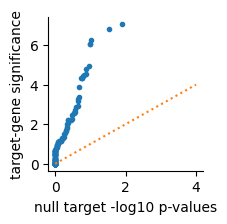

In [49]:
f,ax =plt.subplots(1,figsize=(2,2))

comms = set(adj_real.columns) & set(adj_shuff.columns)
ax.plot(-1*np.log10(adj_shuff.loc[:,comms].min(axis=0)).sort_values(),-1*np.log10(adj_real.loc[:,comms].min(axis=0)).sort_values(),'.')
ax.plot([0,4],[0,4],':')
ax.set_xlabel("null target -log10 p-values")
ax.set_ylabel("target-gene significance")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
f.savefig("figures/fig3A_targetscore.png",bbox_inches='tight',dpi=300)

## Fig 2B
Then we get:
- drugs in significant targets above,
- the disease genes associated with those drug target groups but not widely associated with all drugs
- then get the drugs associated with these disease genes for the visualization

80 drugs and 150 disease genes

In [8]:
drug_gene_log = (-1*np.log10(np.clip(drug_gene,10**-5,1)))

In [10]:
adj_real.head()

,Unnamed: 0,CACNA1D-CACNA1S,CACNB1-CACNB3-CACNB4,GABRA3-GABRG2,GABRA4-GABRA6-GABRD-GABRE-GABRG1-GABRG3-GABRP-GABRQ,GABRA5-GABRB2,GABRB1-GABRB3,GLRA2-GLRA3-GLRB,GRIN1-GRIN2D,GRIN2C-GRIN3B,...,GRIN2B,GLRA1,DRD4,RXRG,PTGS2,PPARD,CHRM2,CHRM5,GRIN2A,TYMS
0,TTC30B,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MPZ,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,HLA-DMA,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,...,1.0,NaN,NaN,1.0,NaN,NaN,1.000000,1.000000,1.0,NaN
3,ARGLU1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN
4,KCNK7,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,1.0,NaN,1.0,NaN,NaN,NaN,0.341058,0.589403,1.0,NaN


In [12]:
from itertools import chain

## drugs are signif for at least one 
sigtarg = list(adj_real.loc[:,adj_real.min(axis=0) < .1].columns) ## targets have any signif genes
sigdrug = set(chain.from_iterable([t2d_db[t] for t in sigtarg])) ## drugs in those targets

siggene = adj_real.index[((adj_real.fillna(2) < .05).sum(axis=1) > 0)]  ## gene is signif for at least 1 target

## drugs for these genes; genes is signif for some of them but not for more than 20 drugs
sigdrug_sub = drug_gene_log.loc[sigdrug,:].index[drug_gene_log.loc[sigdrug,siggene].max(axis=1) > 2] 
xsiggene_sub_not_broad = drug_gene_log.loc[:,siggene].columns[(drug_gene_log.loc[sigdrug_sub,siggene].abs() > 2).sum(axis=0) < 20]
xdrug_gene_not_broad = (drug_gene_log.loc[sigdrug,xsiggene_sub_not_broad].abs() > 2).sum(axis=1)
xdrug_gene_not_broad = xdrug_gene_not_broad.loc[xdrug_gene_not_broad > 0 ].index

In [13]:
to_pc_8 = drug_gene_log.loc[xdrug_gene_not_broad,xsiggene_sub_not_broad].transpose().corr(method='spearman')


Get ATC categorization..

In [17]:
id2name, name2id = setup_data.get_id2name()

lev = 1
import json
atc = json.loads(open("../../data/cidATC.json").read())
atc_scrape = pd.read_csv("../../data/atc_info_scraped.csv")
atc_scrape.set_index('class_code',inplace=True)
def atcdic(lev):
    drug2lev = {id2name[k]:set([vi[:lev] for vi in v]) for k,v in atc.items() if v !=['NONE']}
    lev2d = {t:[k for k,v in drug2lev.items() if t in v] 
         for t in set(chain.from_iterable(drug2lev.values())) - set(['NONE'])}
    lev2d = {k +('-' + atc_scrape.loc[k,'class_name'] if k in atc_scrape.index else ''):v 
                 for k,v in lev2d.items() if len(v)  > 2}
    drug2lev = {k:set([v + ('-'+atc_scrape.loc[v,'class_name']) if v in atc_scrape.index else ''
                      for v in vv])
                for k,vv in drug2lev.items()}

    return drug2lev, lev2d
d2lev3, lev32d = atcdic(3)


In [5]:
open("intermediate_files/ATC_lev3_drug.json",'w').write(json.dumps(lev32d))

8202

In [9]:
d2lev3, lev32d = atcdic(4)

In [11]:
len(lev32d.keys())

63

Then, we project this matrix on to 2 dimensions using TSNE to visualize the similarity of drugs in different ATC classes. Note that becuase there is a random element to TSNE this will look slightly different each time it is run.

/modules/apps/anaconda/2022.10/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/modules/apps/anaconda/2022.10/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


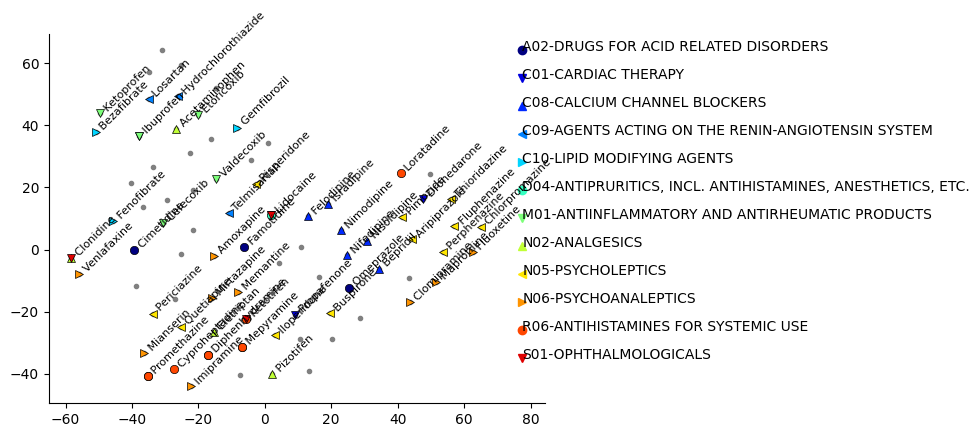

In [53]:
from sklearn.manifold import TSNE
pcd = TSNE(n_components=2).fit_transform(to_pc_8) #by_log.loc[:,siggene_sub_not_broad])
pcd = pd.DataFrame(pcd, index= to_pc_8.index)
lab = True


import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt


jet = plt.get_cmap('jet')
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
f,ax = plt.subplots(1)
ax.plot(pcd[0],pcd[1],'.',color='gray')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
moa_plot = {k:v for k,v in lev32d.items() if len(set(v) & set(pcd.index)) >2}
cNorm = colors.Normalize(vmin=0,vmax=len(moa_plot))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
marker = ["o","v","^","<",">"]
yrange = pcd[1].max()- pcd[1].min()
xrange = pcd[0].max()- pcd[0].min()
dplotted = []
for ix, m in enumerate(sorted(moa_plot.keys())):
    col = scalarMap.to_rgba(ix)
    d = set(moa_plot[m] ) & set(pcd.index)
    #print(m,len(d))
    ax.plot(pcd.loc[d,0],pcd.loc[d,1],'.',color=col,
            markeredgewidth=.5, markeredgecolor = 'k',marker=marker[ix%len(marker)])
    ax.plot(pcd[0].max() + .1*xrange,pcd[1].max() - yrange/len(moa_plot)*ix, marker=marker[ix%len(marker)],color=col)
    ax.text(pcd[0].max() + .1*xrange,pcd[1].max() - yrange/len(moa_plot) * ix, m) #,color=col)
    if lab:
        for dd in d:
            if dd in dplotted:
                continue
            ax.text(pcd.loc[dd,0],pcd.loc[dd,1],' '+ dd,rotation=45 , fontsize=8) #+ stats.norm.rvs(1,scale=20))
            dplotted.append(dd)

In [ ]:
from sklearn.manifold import TSNE
pcd = TSNE(n_components=2).fit_transform(to_pc_8) #by_log.loc[:,siggene_sub_not_broad])
pcd = pd.DataFrame(pcd, index= to_pc_8.index)
lab = True


[]

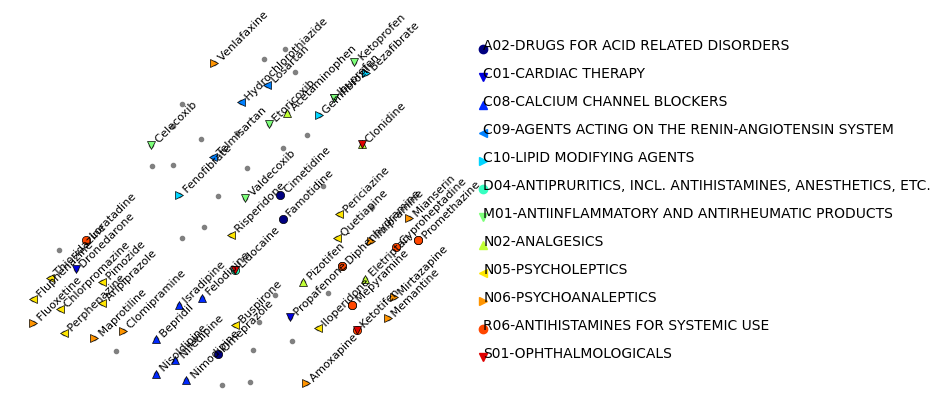

In [21]:


import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt


jet = plt.get_cmap('jet')
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
f,ax = plt.subplots(1)
ax.plot(pcd[0],pcd[1],'.',color='gray')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
moa_plot = {k:v for k,v in lev32d.items() if len(set(v) & set(pcd.index)) >2}
cNorm = colors.Normalize(vmin=0,vmax=len(moa_plot))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
marker = ["o","v","^","<",">"]
yrange = pcd[1].max()- pcd[1].min()
xrange = pcd[0].max()- pcd[0].min()
dplotted = []
for ix, m in enumerate(sorted(moa_plot.keys())):
    col = scalarMap.to_rgba(ix)
    d = set(moa_plot[m] ) & set(pcd.index)
    #print(m,len(d))
    ax.plot(pcd.loc[d,0],pcd.loc[d,1],'.',color=col,
            markeredgewidth=.5, markeredgecolor = 'k',marker=marker[ix%len(marker)])
    ax.plot(pcd[0].max() + .17*xrange,pcd[1].max() - yrange/len(moa_plot)*ix, marker=marker[ix%len(marker)],color=col)
    ax.text(pcd[0].max() + .17*xrange,pcd[1].max() - yrange/len(moa_plot) * ix, m) #,color=col)
    if lab:
        for dd in d:
            if dd in dplotted:
                continue
            ax.text(pcd.loc[dd,0],pcd.loc[dd,1],' '+ dd,rotation=45 , fontsize=8) #+ stats.norm.rvs(1,scale=20))
            dplotted.append(dd)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

In [28]:
(np.random.sample(10)-.5)*.1

array([ 0.04344036,  0.02916809,  0.01090671, -0.04041623, -0.01874211,
        0.04340964,  0.00577298, -0.01875552,  0.04210982,  0.03434682])

## Figure 3C

In [34]:
drug_gene_hits.loc['Bezafibrate',genes_do]

PPM1M     1.0
CETP      1.0
ZNF248    1.0
Name: Bezafibrate, dtype: float64

0


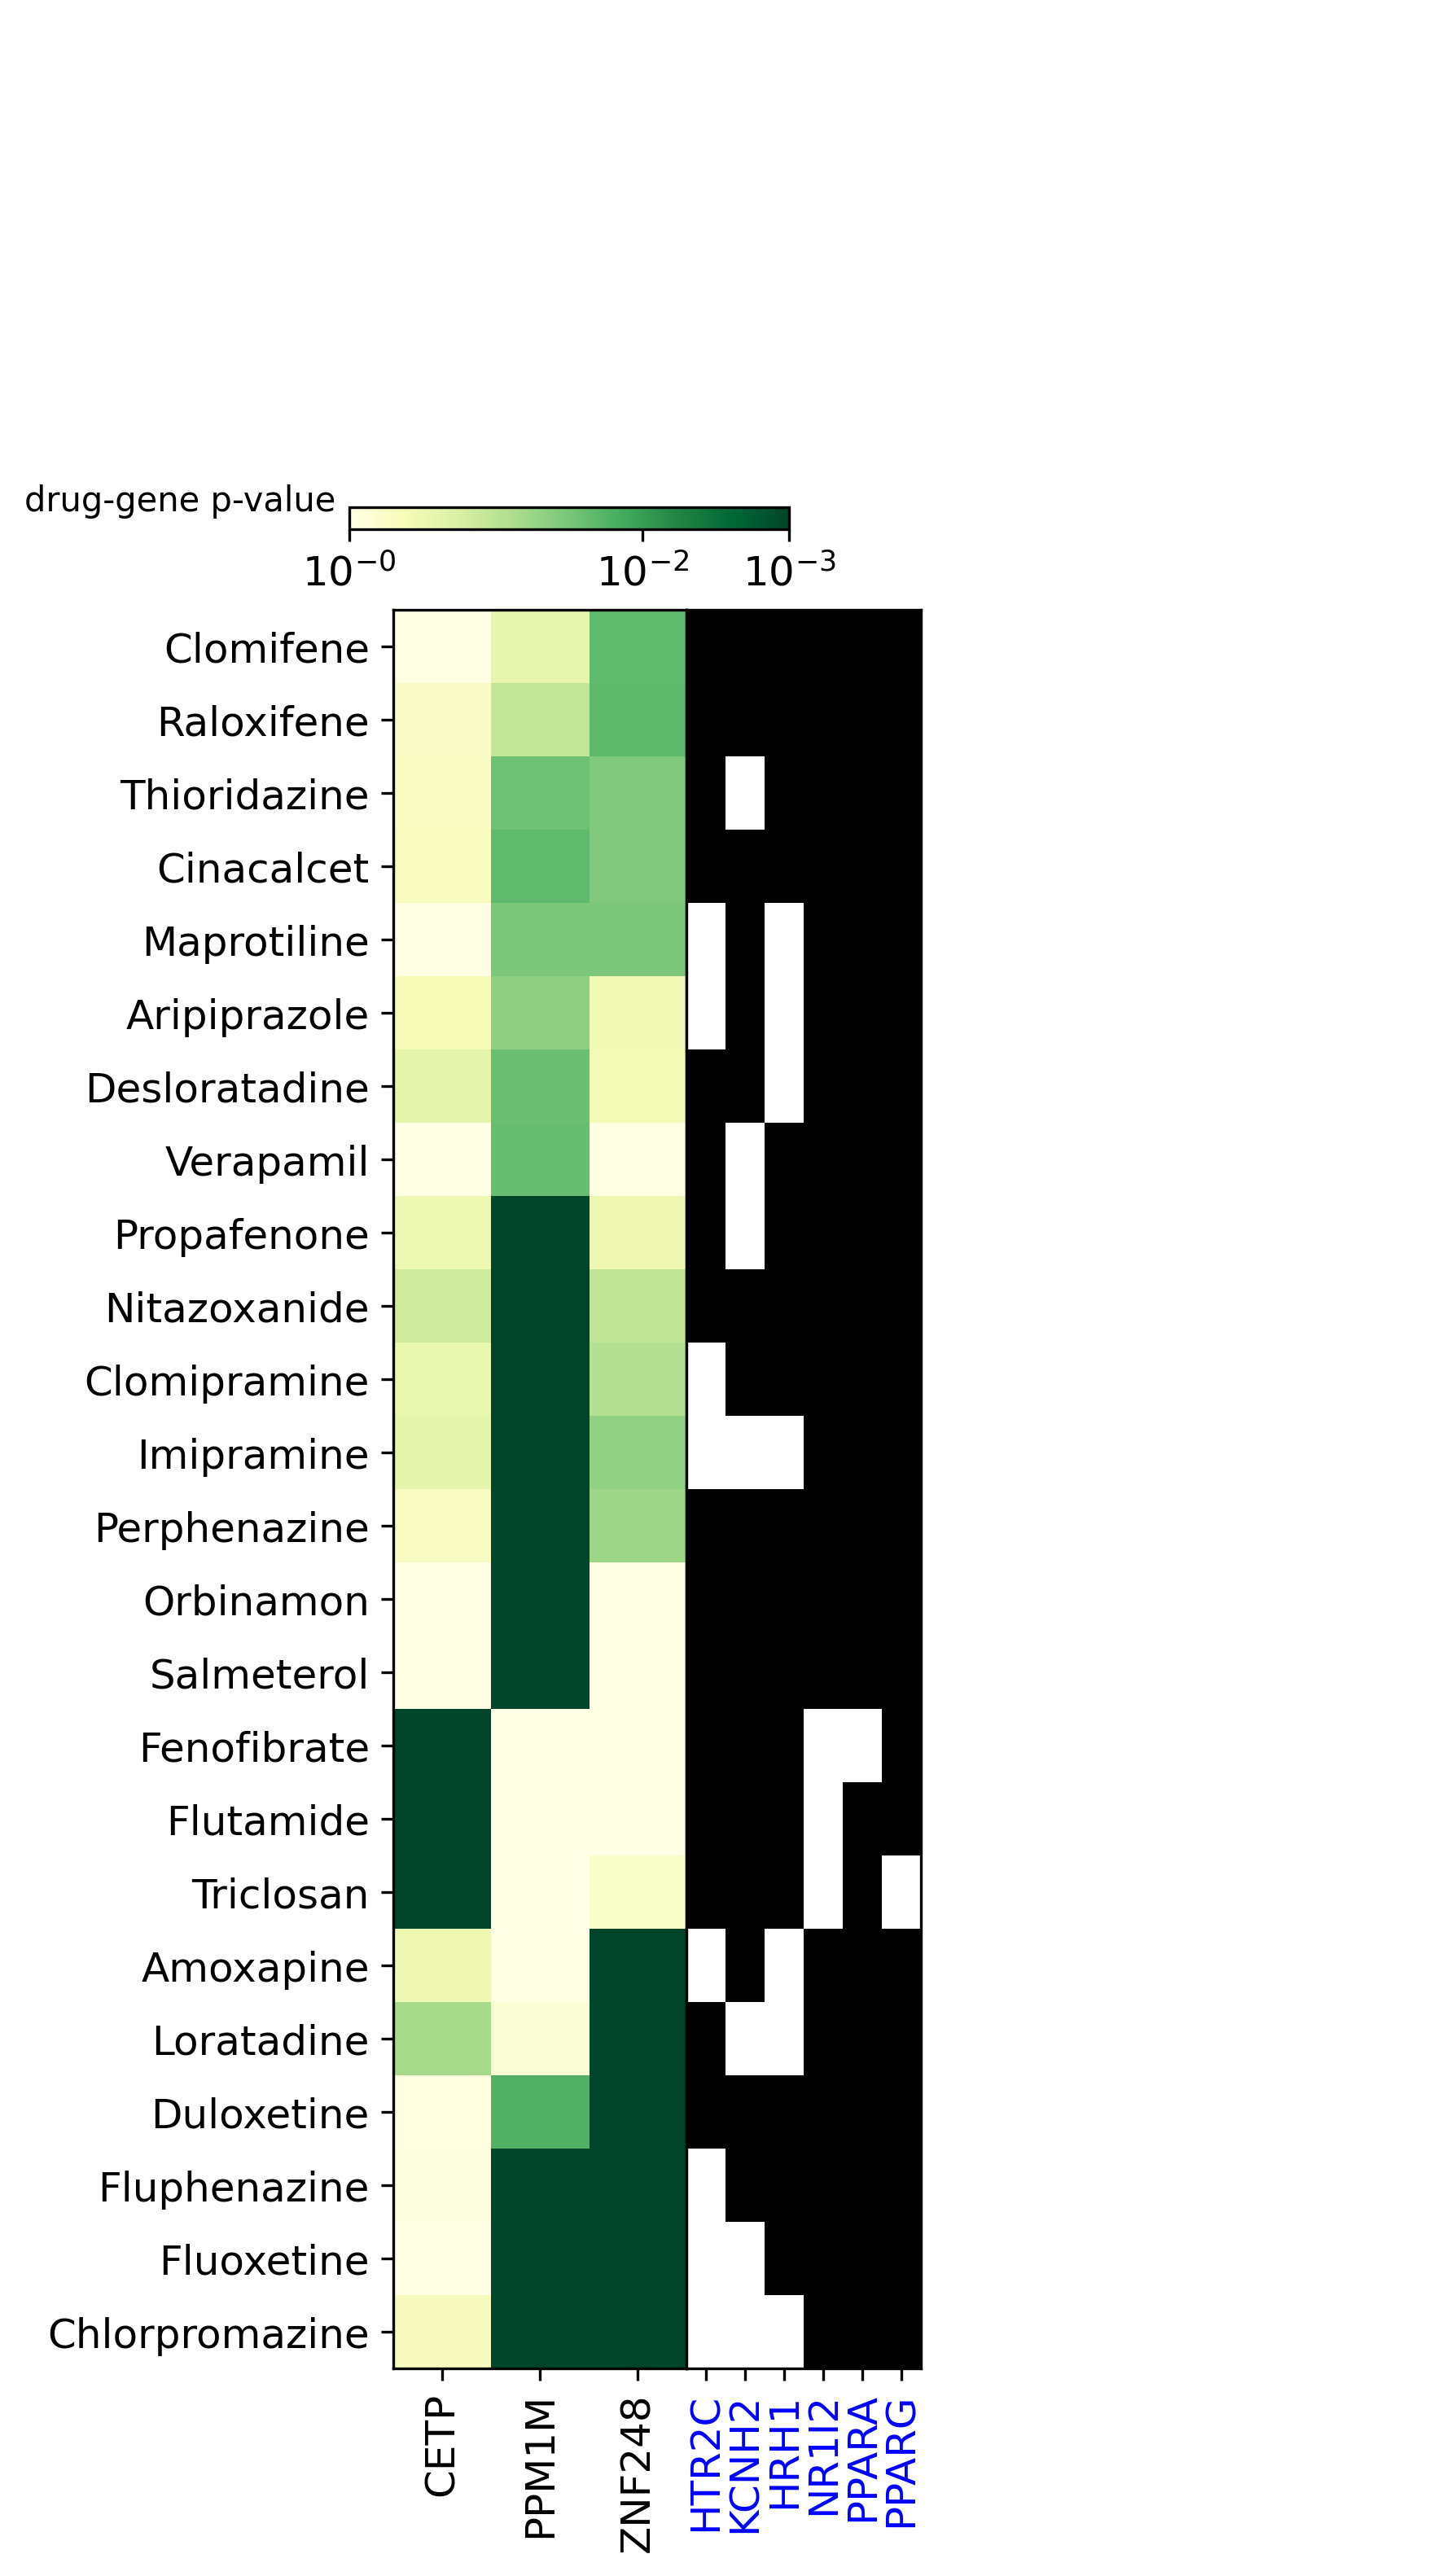

In [193]:
import scipy.cluster.hierarchy as sch
import matplotlib.cm as cmx

targ = ['HTR2C','KCNH2','HRH1','NR1I2','PPARA','PPARG']
genes_do = ['PPM1M','CETP','ZNF248']
add = drug_gene_hits.index[drug_gene_hits.loc[:,genes_do].min(axis=1) < 0.05]
drugs = ( set(add) ) 
for_plot = drug_gene_log.loc[drugs, genes_do] 
dat = for_plot
no_row_dendrogram = True
no_col_dendrogram = True

cmax = 3
sz = 6
tickfont = 12 
imgheight = .6
imgwidth = .2
imgbottom = .1    
imgleft = .09  

fig = plt.figure(figsize=(sz,sz*2),dpi=300)
dat = dat.loc[:,genes_do]
Y = sch.linkage(dat, method='complete') #,metric='correlation')
## add_axes([l, b, w, h])

ax = fig.add_axes([0.7,imgbottom,0.08,imgheight])
Z1 = sch.dendrogram(Y, orientation='right',no_plot=no_row_dendrogram)
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()
yidx = Z1['leaves']
#idx1 = idx1[-1:0:-1]
yidx.reverse()

targmat = pd.DataFrame(np.zeros((dat.shape[0],len(targ))),
                       index = [dat.index[i] for i in yidx], columns = targ)
for t in targ:
    targmat.loc[set(t2d[t]) & set(targmat.index),t] = 1
    
class_cor = dat.copy()
xidx = range(class_cor.shape[1])
ax = fig.add_axes([imgleft,imgbottom + imgheight,imgwidth,.2])
horztree = sch.linkage(dat.transpose(), method='complete')
                       #metric = 'correlation') #lambda u,v: stats.spearmanr(u,v)[0])    
Z2 = sch.dendrogram(horztree, no_plot=no_col_dendrogram) #orientation='top')

ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()

xidx = Z2['leaves']

axmatrix = fig.add_axes([0.09,imgbottom,imgwidth,imgheight])
cmin = 0
#cmap.set_bad('white',1.)\
a = class_cor.iloc[yidx, xidx]
#return a
masked_array = np.ma.array (a, mask=pd.isnull(a))
cmap = cmx.get_cmap('YlGn')
print( pd.isnull(a).sum().sum())
#cmap.set_bad('black',1.)

cax = axmatrix.imshow(masked_array,  cmap=cmap,vmin=cmin, vmax = cmax, #-1*absmax, vmax=absmax,
                      interpolation='nearest', aspect = 'auto')

axmatrix.set_xticks(range(class_cor.shape[1]))
axmatrix.set_yticks(range(class_cor.shape[0]))
axmatrix.set_xticklabels(class_cor.iloc[:,xidx].columns,rotation=90,fontsize=tickfont)
ylab = class_cor.iloc[yidx,:].index.str.replace(" hydrochloride","")
ylab = [yl if len(yl) < 20 else yl[-20:] for yl in ylab]
axmatrix.set_yticklabels(ylab,fontsize=tickfont) #.iloc[yidx,:]
ylm = axmatrix.get_ylim()

axcompp = fig.add_axes([imgwidth + 0.09,imgbottom,imgwidth*.8,imgheight])
yord = class_cor.iloc[yidx,:].index
blah = axcompp.imshow(targmat.loc[yord,:],  cmap='bone',#vmin=-5, vmax = 5, #-1*absmax, vmax=absmax,
                          interpolation='nearest', aspect = 'auto')
xlim = axcompp.get_xlim()
ylim = axcompp.get_ylim()
axcompp.set_xticks(np.arange(targmat.shape[1]))
axcompp.set_xticklabels(targmat.columns,rotation=90,color='blue',fontsize=tickfont )
axcompp.set_yticks([])
#axcompp.set_yticks(range(class_cor.shape[0]))
#axcompp.set_yticklabels(targmat.loc[yord,:].index,fontsize=tickfont) #.iloc[yidx,:]

axcbar = fig.add_axes([imgwidth*.3 ,imgheight+imgbottom + .02,0.3,0.1])
axcbar.set_xticks([])
axcbar.set_yticks([])
#axcbar.set_axes([])
axcbar.set_axis_off()
val = [round(i) for i in np.linspace(cmin,cmax,3)]
cbar = fig.colorbar(cax, ax=axcbar,
                    ticks=val, #[round(i,2) for i in np.linspace(cmin,cmax,7)],
                    orientation='horizontal')
cbar.ax.set_xticklabels([r'$10^{-'+str(int(i))+"}$" for i in val],fontsize=tickfont ) #['< -1', '0', '> 1']) 
cbar.ax.set_ylabel("drug-gene p-value") #significance of drug-gene importance",rotation=90)
cbar.ax.yaxis.label.set_rotation(0)
cbar.ax.yaxis.label.set_horizontalalignment('right')
fig.savefig("figures/drug_target_gene.png",dpi=300, bbox_inches='tight')

0


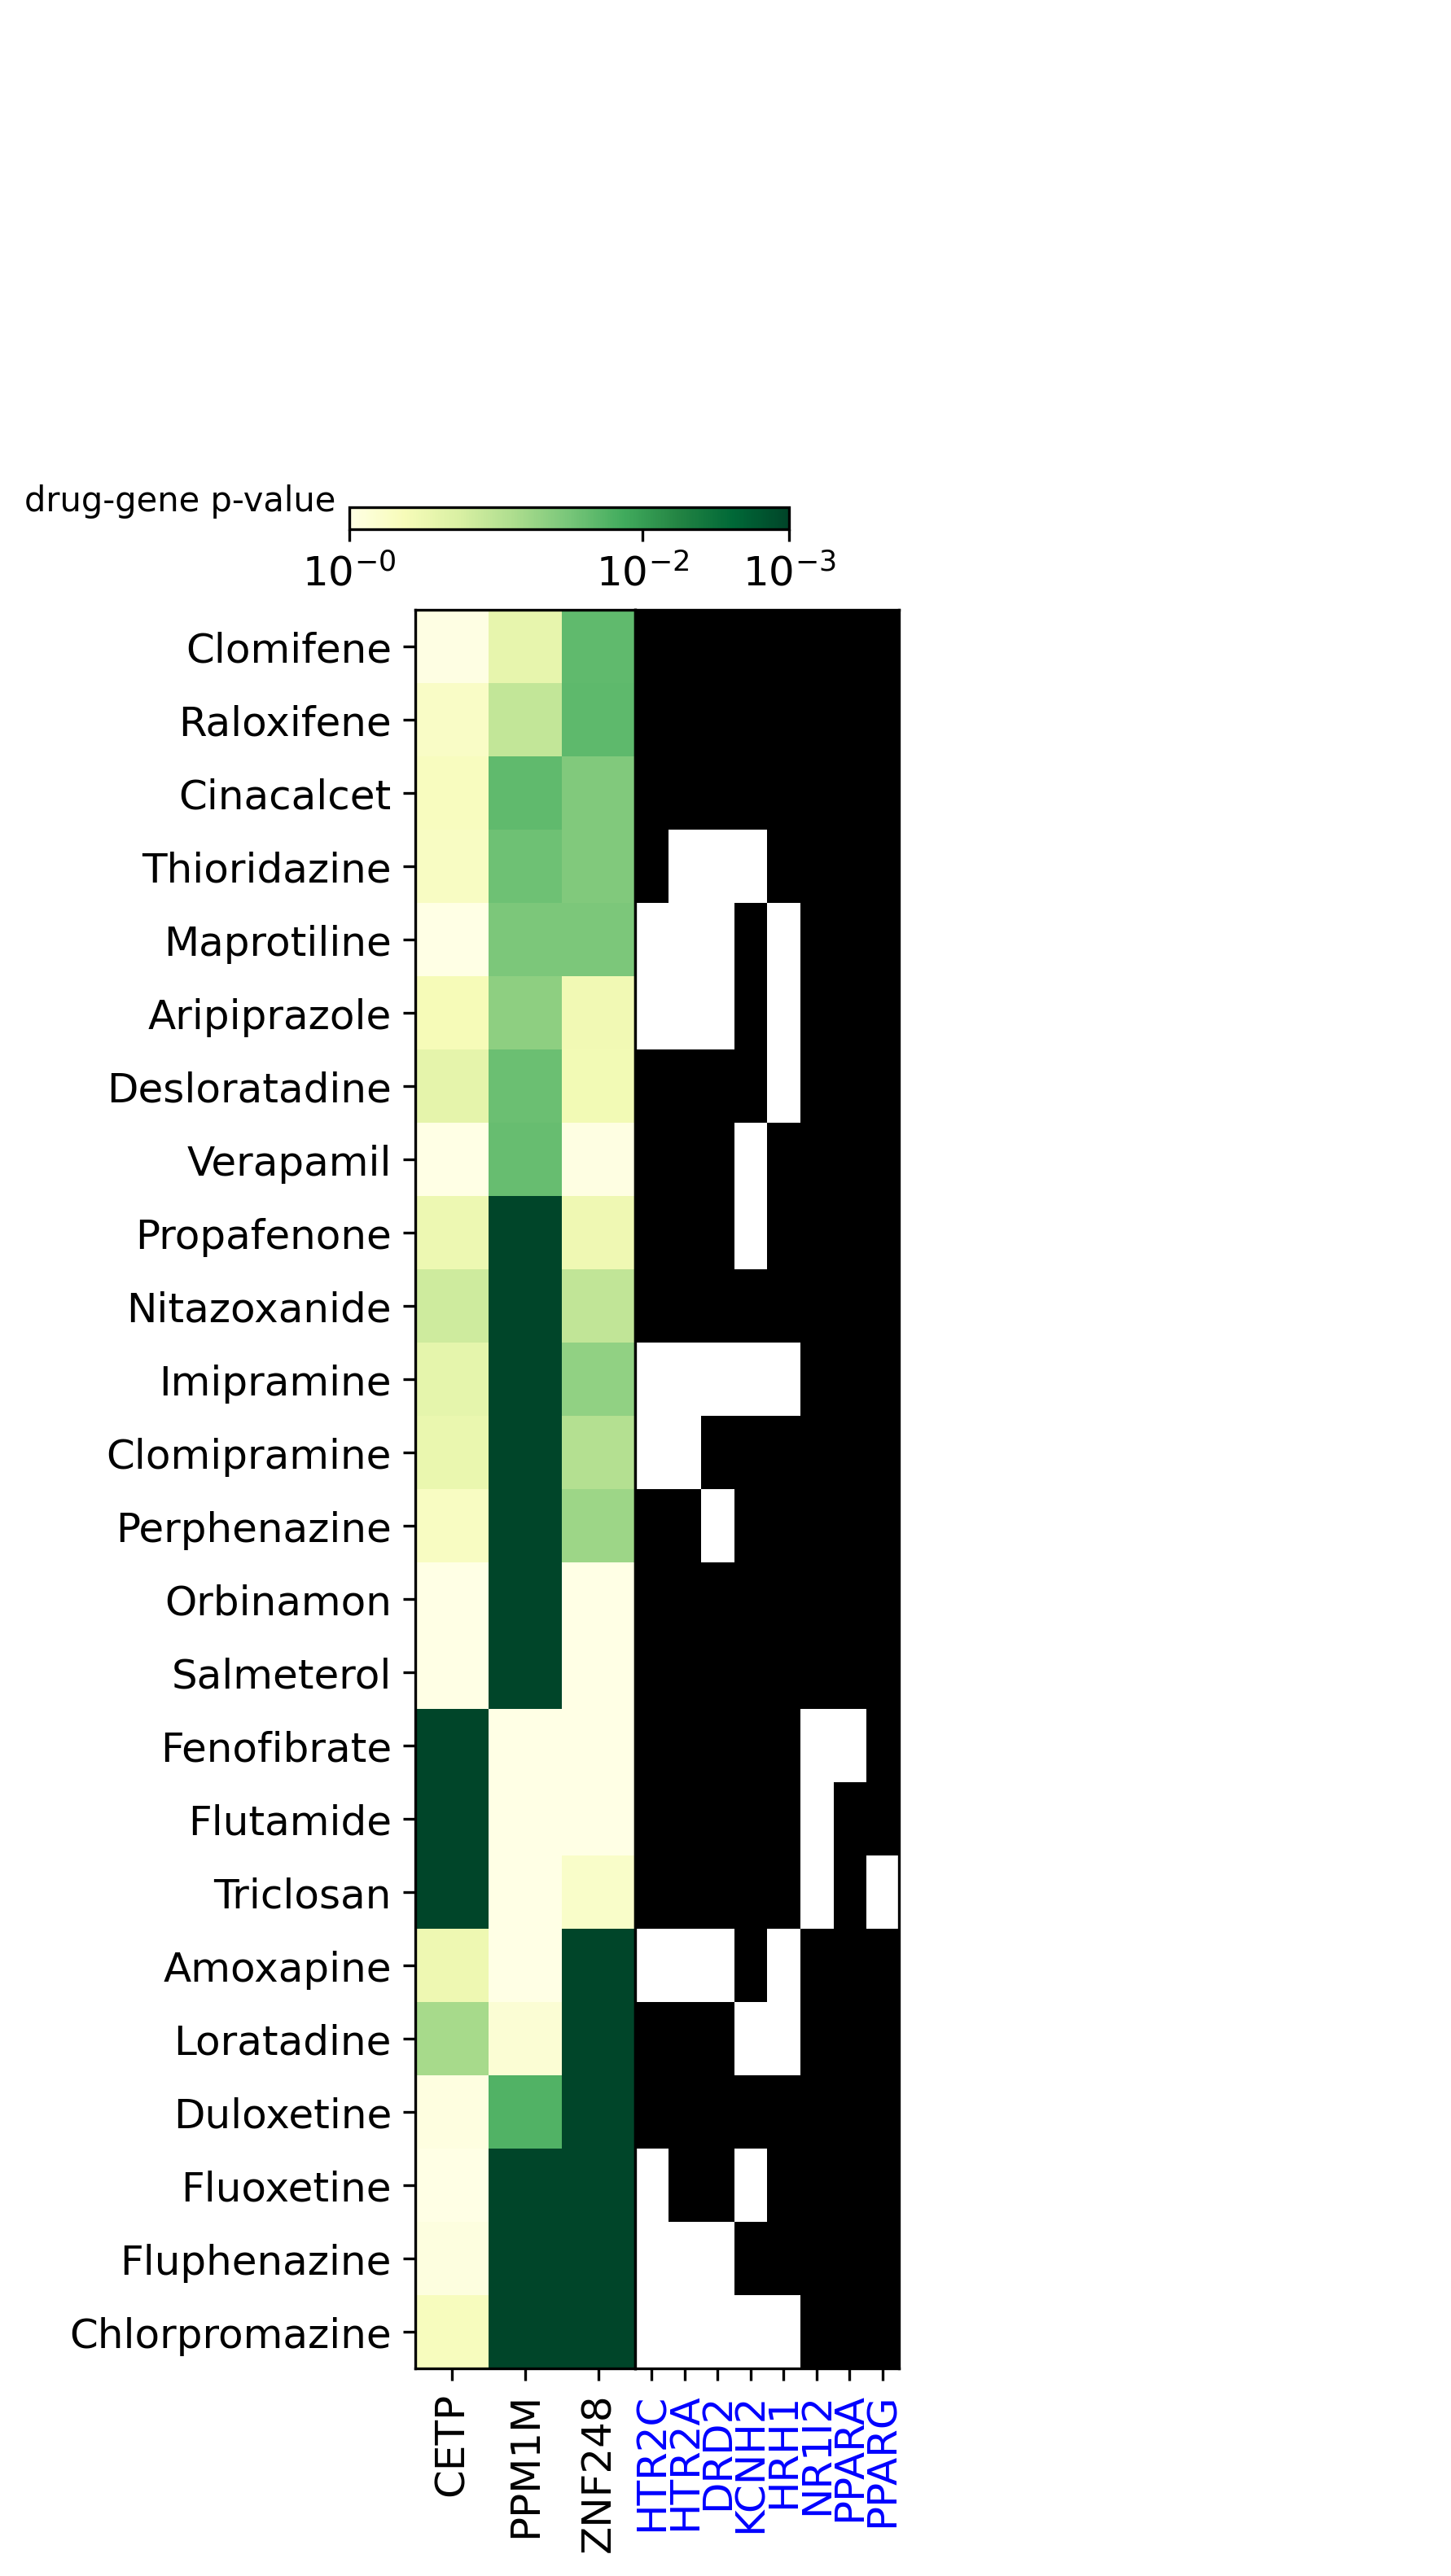

In [33]:
import scipy.cluster.hierarchy as sch
import matplotlib.cm as cmx

targ = ['HTR2C','HTR2A','DRD2','KCNH2','HRH1','NR1I2','PPARA','PPARG']
genes_do = ['PPM1M','CETP','ZNF248']
add = drug_gene_hits.index[drug_gene_hits.loc[:,genes_do].min(axis=1) < 0.05]
drugs = ( set(add) ) 
for_plot = drug_gene_log.loc[drugs, genes_do] 
dat = for_plot
no_row_dendrogram = True
no_col_dendrogram = True

cmax = 3
sz = 6
tickfont = 12 
imgheight = .6
imgwidth = .15
imgbottom = .1    
imgleft = .09  

fig = plt.figure(figsize=(sz,sz*2),dpi=300)
dat = dat.loc[:,genes_do]
Y = sch.linkage(dat, method='complete') #,metric='correlation')
## add_axes([l, b, w, h])

ax = fig.add_axes([0.7,imgbottom,0.08,imgheight])
Z1 = sch.dendrogram(Y, orientation='right',no_plot=no_row_dendrogram)
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()
yidx = Z1['leaves']
#idx1 = idx1[-1:0:-1]
yidx.reverse()

targmat = pd.DataFrame(np.zeros((dat.shape[0],len(targ))),
                       index = [dat.index[i] for i in yidx], columns = targ)
for t in targ:
    targmat.loc[set(t2d_db[t]) & set(targmat.index),t] = 1
    
class_cor = dat.copy()
xidx = range(class_cor.shape[1])
ax = fig.add_axes([imgleft,imgbottom + imgheight,imgwidth,.2])
horztree = sch.linkage(dat.transpose(), method='complete')
                       #metric = 'correlation') #lambda u,v: stats.spearmanr(u,v)[0])    
Z2 = sch.dendrogram(horztree, no_plot=no_col_dendrogram) #orientation='top')

ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()

xidx = Z2['leaves']

axmatrix = fig.add_axes([0.09,imgbottom,imgwidth,imgheight])
cmin = 0
#cmap.set_bad('white',1.)\
a = class_cor.iloc[yidx, xidx]
#return a
masked_array = np.ma.array (a, mask=pd.isnull(a))
cmap = cmx.get_cmap('YlGn')
print( pd.isnull(a).sum().sum())
#cmap.set_bad('black',1.)

cax = axmatrix.imshow(masked_array,  cmap=cmap,vmin=cmin, vmax = cmax, #-1*absmax, vmax=absmax,
                      interpolation='nearest', aspect = 'auto')

axmatrix.set_xticks(range(class_cor.shape[1]))
axmatrix.set_yticks(range(class_cor.shape[0]))
axmatrix.set_xticklabels(class_cor.iloc[:,xidx].columns,rotation=90,fontsize=tickfont)
ylab = class_cor.iloc[yidx,:].index.str.replace(" hydrochloride","")
ylab = [yl if len(yl) < 20 else yl[-20:] for yl in ylab]
axmatrix.set_yticklabels(ylab,fontsize=tickfont) #.iloc[yidx,:]
ylm = axmatrix.get_ylim()

axcompp = fig.add_axes([imgwidth + imgleft,imgbottom,imgwidth*1.2,imgheight])
yord = class_cor.iloc[yidx,:].index
blah = axcompp.imshow(targmat.loc[yord,:],  cmap='bone',#vmin=-5, vmax = 5, #-1*absmax, vmax=absmax,
                          interpolation='nearest', aspect = 'auto')
xlim = axcompp.get_xlim()
ylim = axcompp.get_ylim()
axcompp.set_xticks(np.arange(targmat.shape[1]))
axcompp.set_xticklabels(targmat.columns,rotation=90,color='blue',fontsize=tickfont )
axcompp.set_yticks([])
#axcompp.set_yticks(range(class_cor.shape[0]))
#axcompp.set_yticklabels(targmat.loc[yord,:].index,fontsize=tickfont) #.iloc[yidx,:]

axcbar = fig.add_axes([imgwidth*.3 ,imgheight+imgbottom + .02,0.3,0.1])
axcbar.set_xticks([])
axcbar.set_yticks([])
#axcbar.set_axes([])
axcbar.set_axis_off()
val = [round(i) for i in np.linspace(cmin,cmax,3)]
cbar = fig.colorbar(cax, ax=axcbar,
                    ticks=val, #[round(i,2) for i in np.linspace(cmin,cmax,7)],
                    orientation='horizontal')
cbar.ax.set_xticklabels([r'$10^{-'+str(int(i))+"}$" for i in val],fontsize=tickfont ) #['< -1', '0', '> 1']) 
cbar.ax.set_ylabel("drug-gene p-value") #significance of drug-gene importance",rotation=90)
cbar.ax.yaxis.label.set_rotation(0)
cbar.ax.yaxis.label.set_horizontalalignment('right')
fig.savefig("figs/drug_target_gene.pdf",dpi=300, bbox_inches='tight')
fig.savefig("figs/drug_target_gene.png",dpi=300, bbox_inches='tight')